In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Washburn2019r

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp07-washburn2019r'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-values.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	}
}

# Ensure correct 
config['output']['length'] = len(tpm_order[config['output']['group0']])

In [7]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 910492968


## 2.1 Data

In [8]:
# Get the correct output group

gene_targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [9]:
# Transform the data dictionaries into lists

names = sorted(list(gene_sequences.keys()))

sequences = numpy.array([gene_sequences[key] for key in names])
features  = numpy.array([gene_frequency[key] for key in names])
targets   = numpy.array([gene_targets[key]   for key in names])

In [10]:
# Create the dataset and generte split indices using sklearn

dataset = GeneDataset(
	names       = names,
	sequences   = sequences,
	features    = features,
	targets     = targets,
	expand_dims = 0
)

train_idx, valid_idx, test_idx = cnn_dataset.generate_split_indices(
	targets     = targets,
	valid_split = config['split_size']['valid'],
	test_split  = config['split_size']['test'],
	random_seed = config['random_seed']
)

In [11]:
# Create train dataloader and display batch dimensions

train_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = train_idx,
	batch_size = config['batch_size']['train']
)

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    316
Dataloader sample count : 20,224

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [12]:
# Create valid dataloader and display batch dimensions

valid_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = valid_idx,
	batch_size = config['batch_size']['valid']
)

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     79
Dataloader sample count :  5,056

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [13]:
# Create test dataloader and display batch dimensions

test_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = test_idx,
	batch_size = config['batch_size']['test']
)

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

### 2.2.1 Structure

In [14]:
# Create and display the model structure

model = Washburn2019r(params = {
	'other' : {
		'in_channels' : config['input']['channels'],
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'kernel'  : (4, 11),
		'padding' : (0, 0)
	},
	'conv2' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv3' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv4' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv5' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv6' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'maxpool1' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'maxpool2' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'maxpool3' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'fc3' : {
		'features' : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_channels = config['input']['channels'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Washburn2019r                            [64, 1, 4, 2150]          [64, 8]                   --
├─Washburn2019: 1-1                      [64, 1, 4, 2150]          [64, 32]                  --
│    └─Conv2d: 2-1                       [64, 1, 4, 2150]          [64, 64, 1, 2140]         2,880
│    └─ReLU: 2-2                         [64, 64, 1, 2140]         [64, 64, 1, 2140]         --
│    └─Conv2d: 2-3                       [64, 64, 1, 2140]         [64, 64, 1, 2140]         45,120
│    └─ReLU: 2-4                         [64, 64, 1, 2140]         [64, 64, 1, 2140]         --
│    └─MaxPool2d: 2-5                    [64, 64, 1, 2140]         [64, 64, 1, 714]          --
│    └─Dropout: 2-6                      [64, 64, 1, 714]          [64, 64, 1, 714]          --
│    └─Conv2d: 2-7                       [64, 64, 1, 714]          [64, 128, 1, 714]         90,240
│    └─ReLU: 2-8        

In [15]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

### 2.2.2 Parameters

In [16]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean',
	weights   = None
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 10,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'huber' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'huber'),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2')
	}
}

## 2.3 Training

In [17]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

### 2.3.1 Visualization

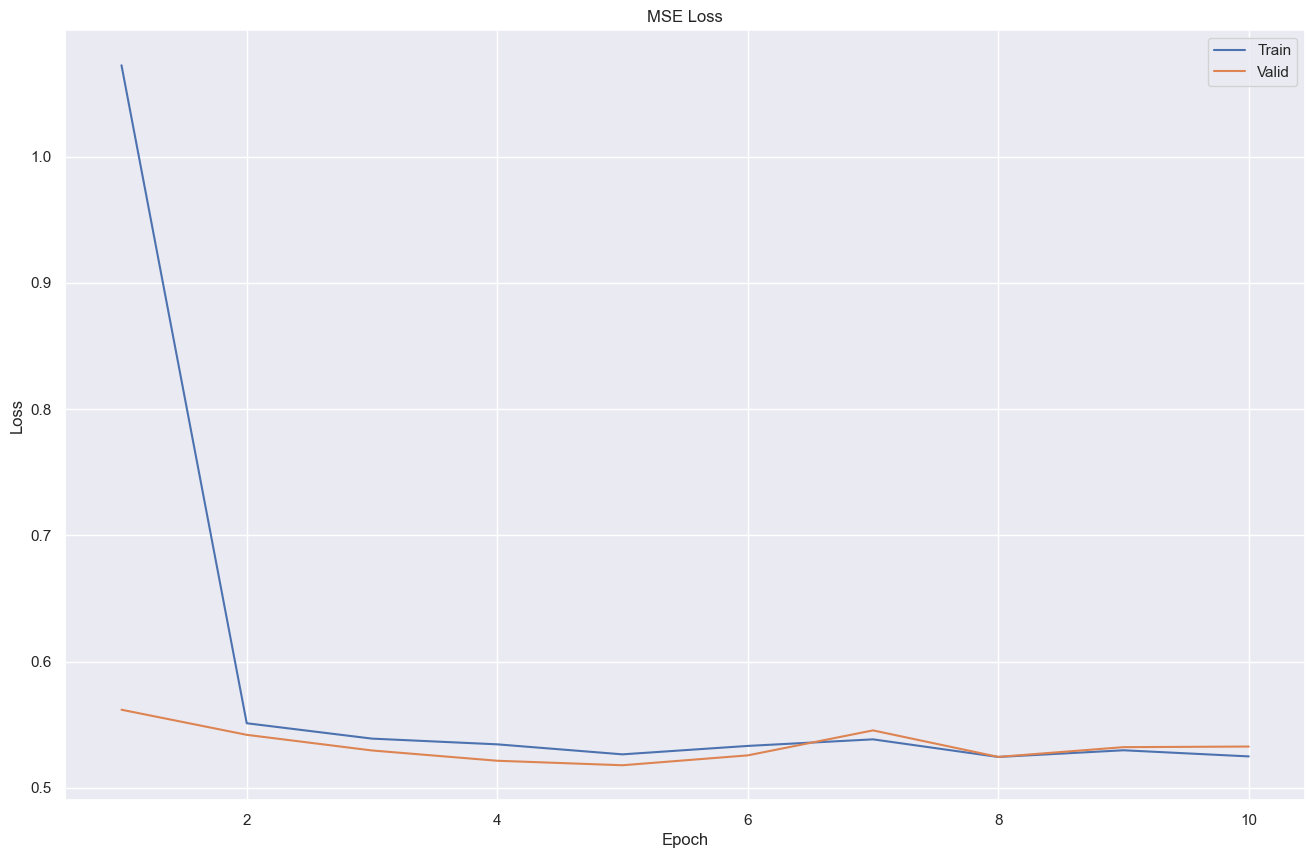

In [18]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

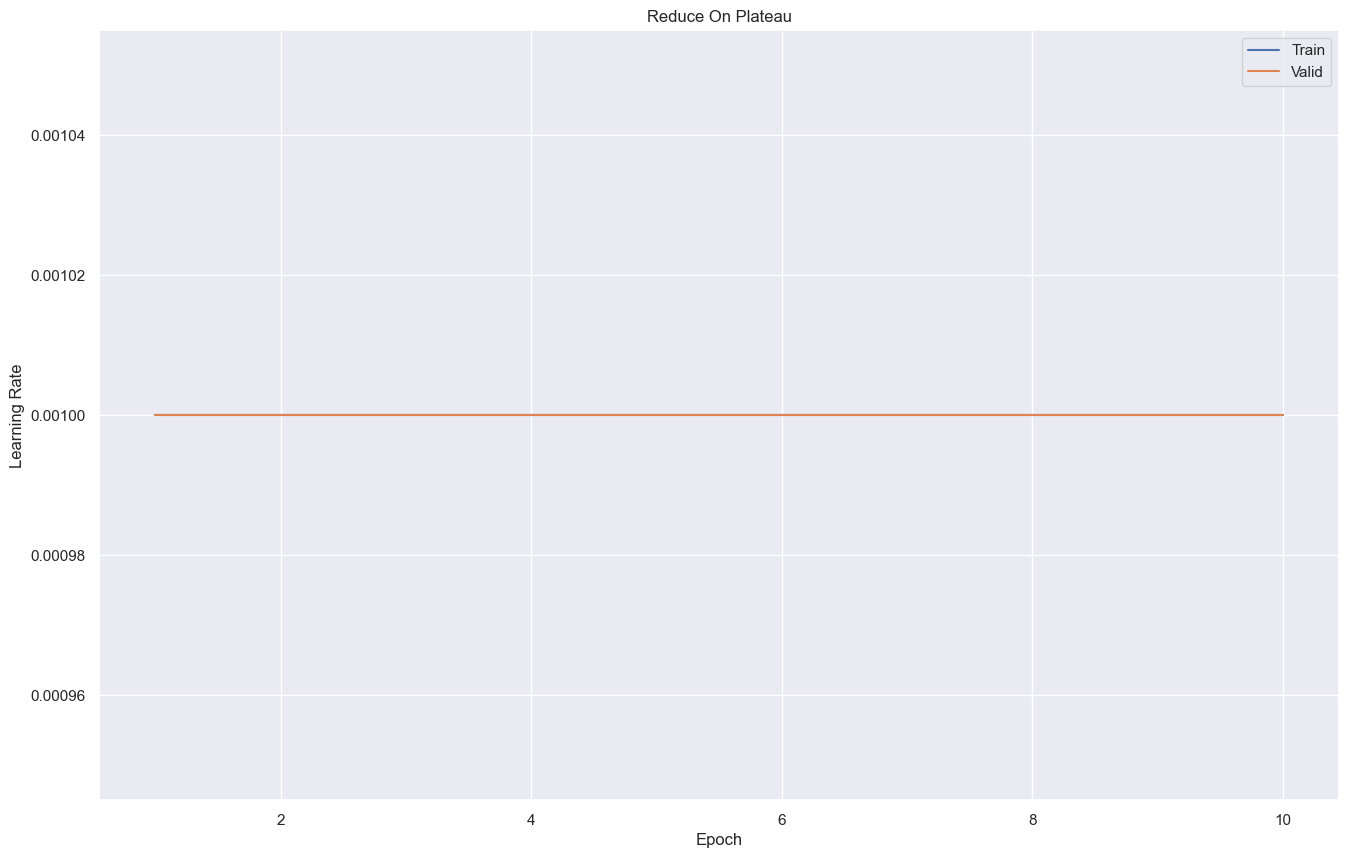

In [19]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

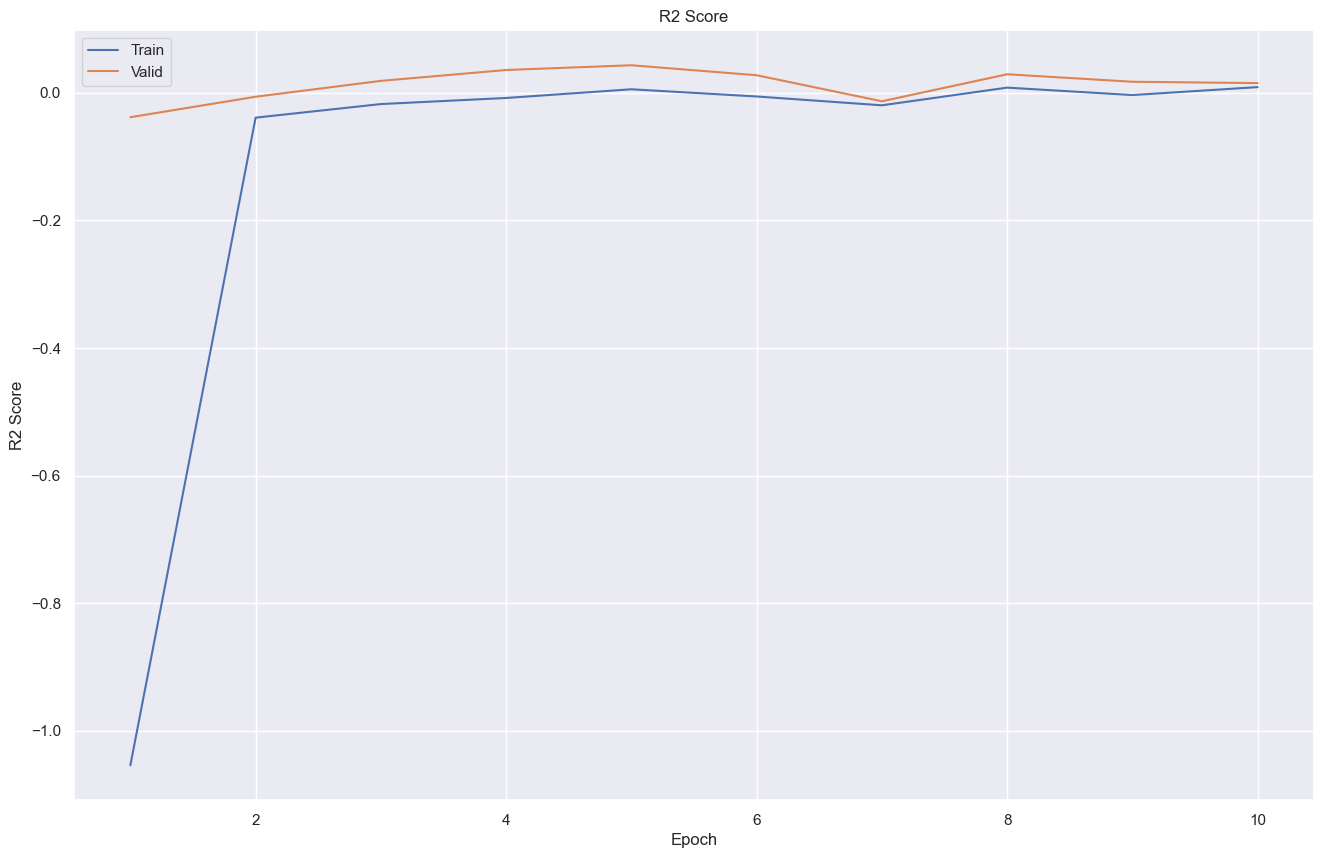

In [20]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

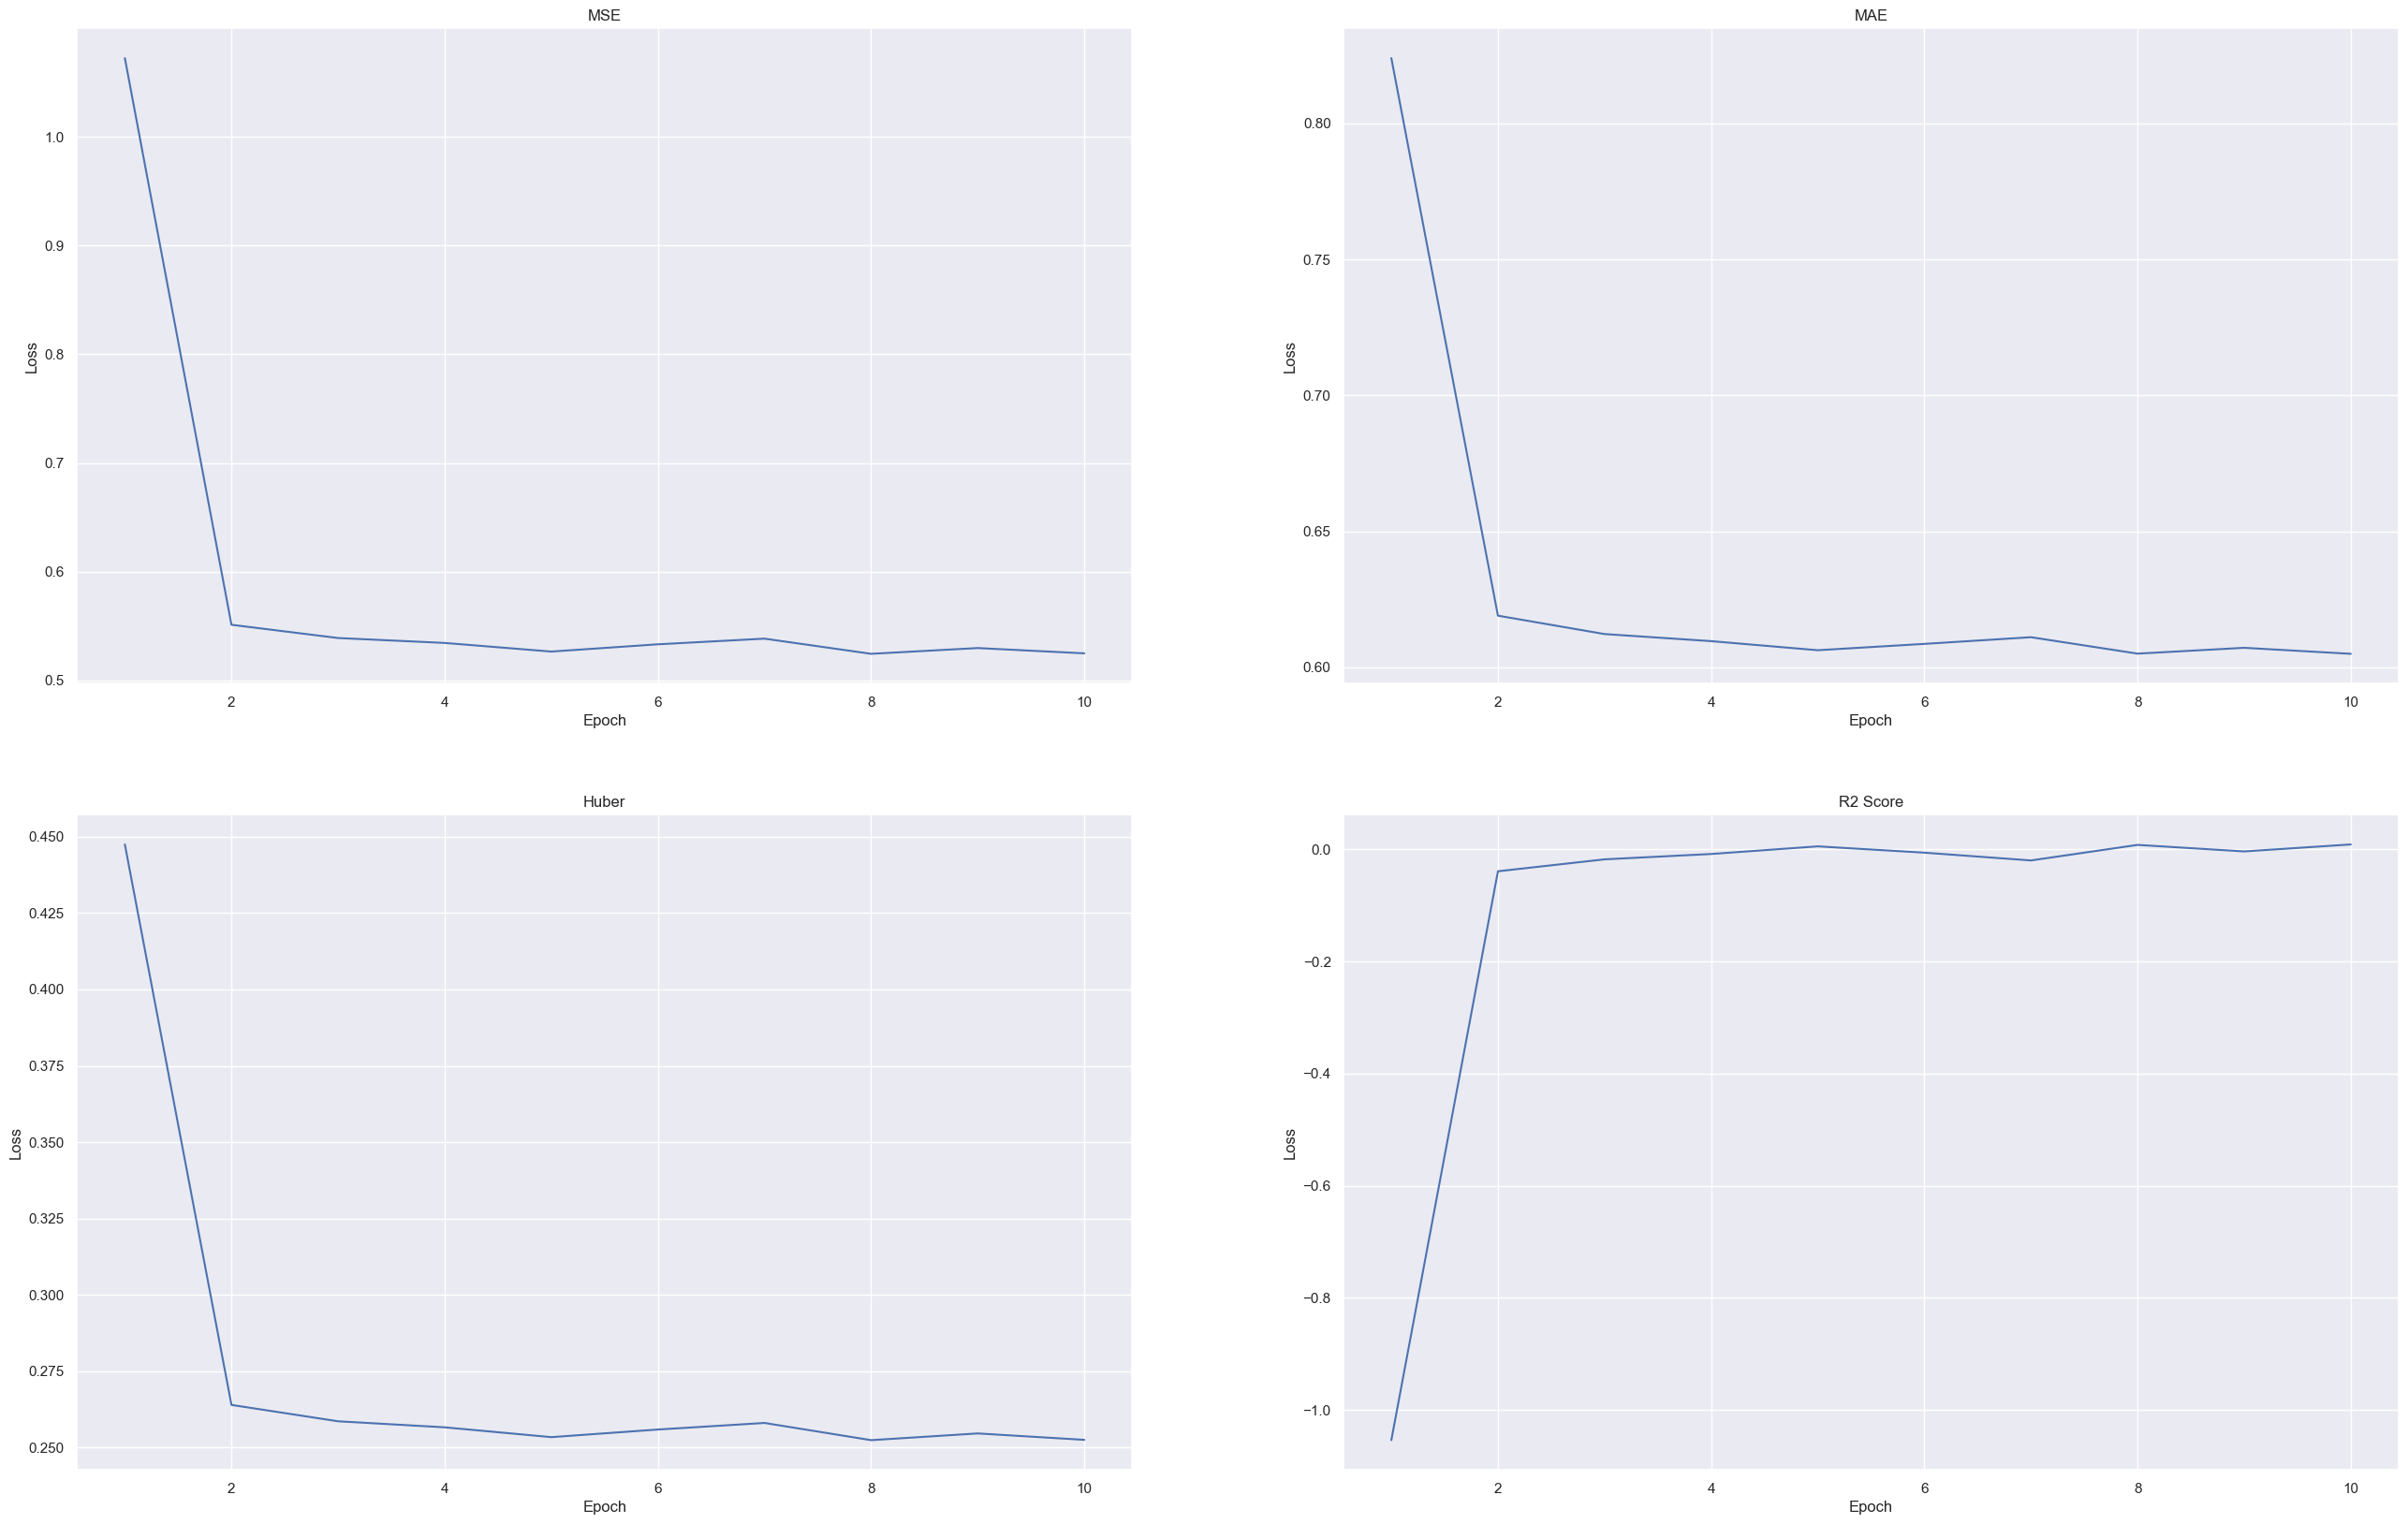

In [21]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

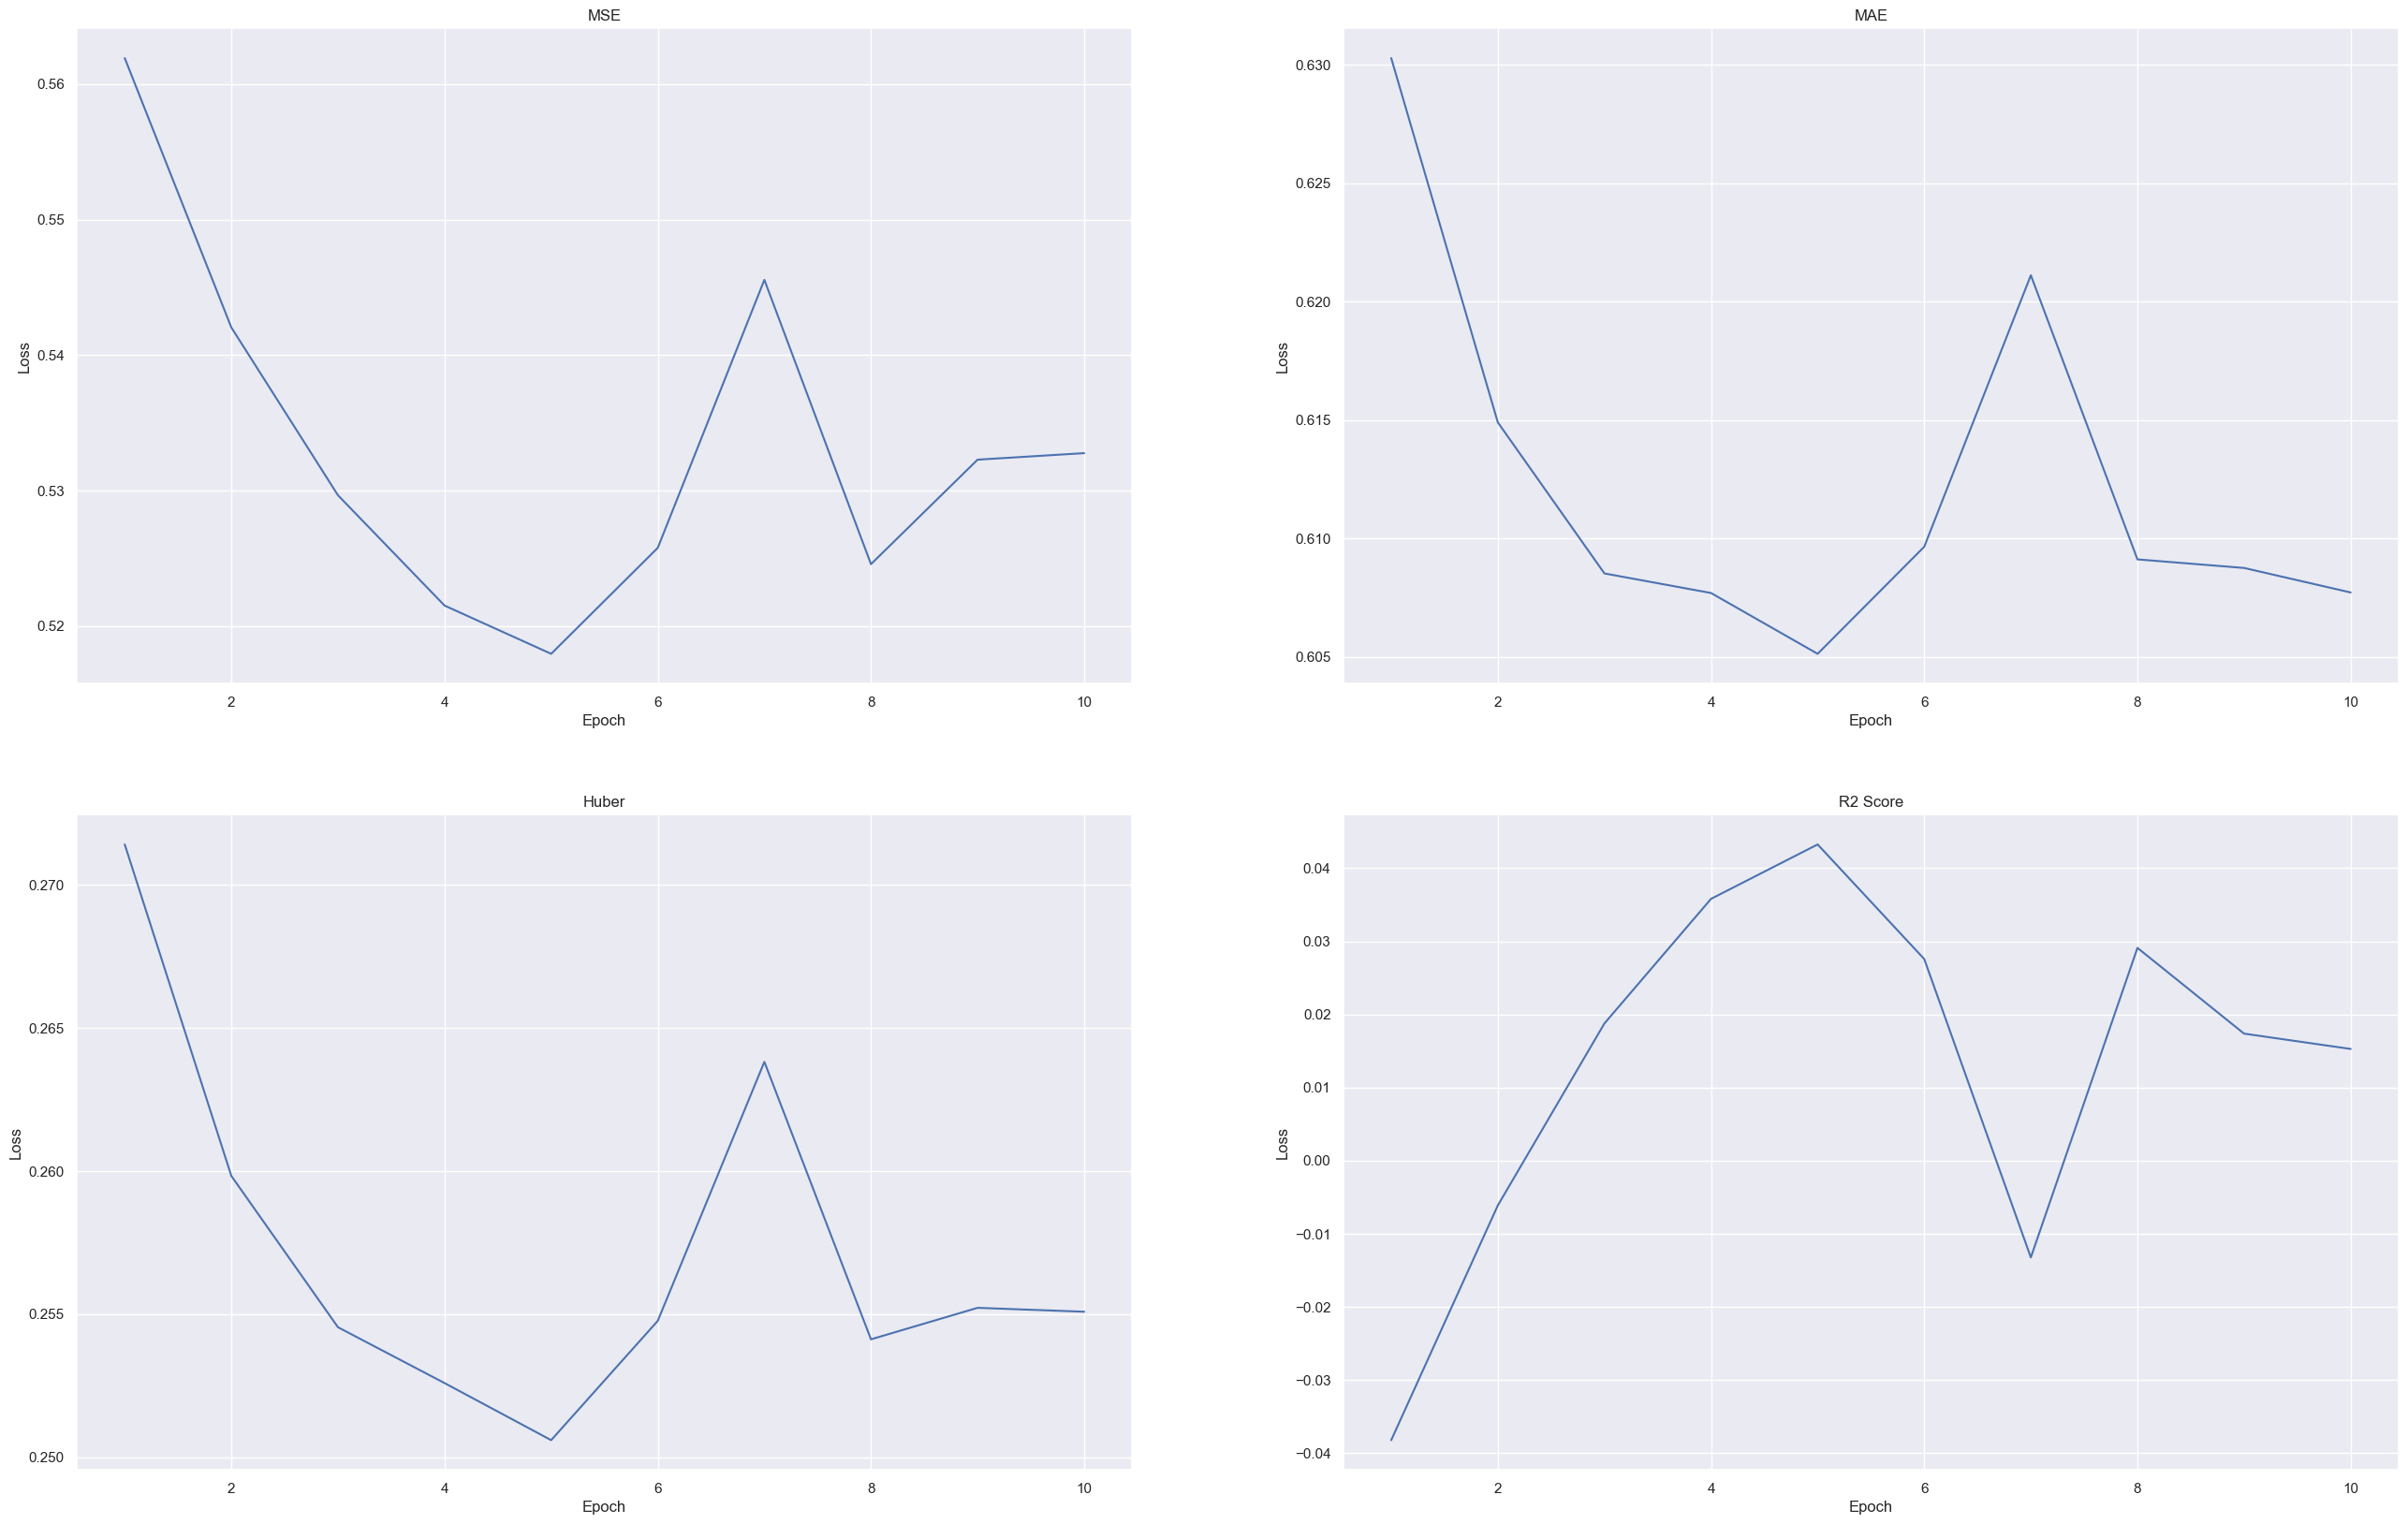

In [22]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [23]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
Loss  : 0.53276


<All keys matched successfully>

In [24]:
# Evaluate the model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [25]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.02116
MAE Loss :  0.60258
MSE Loss :  0.52246


In [26]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT1G11820.1
True : [ 0.58838    0.49369    1.07253    0.55966    0.45960    0.76755    0.17367    0.07464]
Pred : [ 1.53656    1.21294    1.22073    1.40951    1.32413    1.36269    0.99428    0.62620]
 MAE : [ 0.94818    0.71925    0.14820    0.84985    0.86454    0.59514    0.82061    0.55155]
 MSE : [ 0.89905    0.51733    0.02196    0.72224    0.74742    0.35420    0.67340    0.30421]
 R2  : [ 0.11984    0.03541    0.00328    0.02644    0.12557    0.02012   -0.02041    0.09658]

Gene : AT3G59550.1
True : [ 1.52562    0.72585    1.02167    1.19650    0.98825    1.02656    0.16730    0.76358]
Pred : [ 1.54919    1.22312    1.23067    1.42107    1.33526    1.37389    1.00262    0.63151]
 MAE : [ 0.02358    0.49727    0.20901    0.22457    0.34701    0.34733    0.83532    0.13207]
 MSE : [ 0.00056    0.24727    0.04368    0.05043    0.12042    0.12064    0.69776    0.01744]
 R2  : [-0.05590   -0.00569   -0.00002   -0.03552    0.03361   -0.02171    0.02968    0.03256]



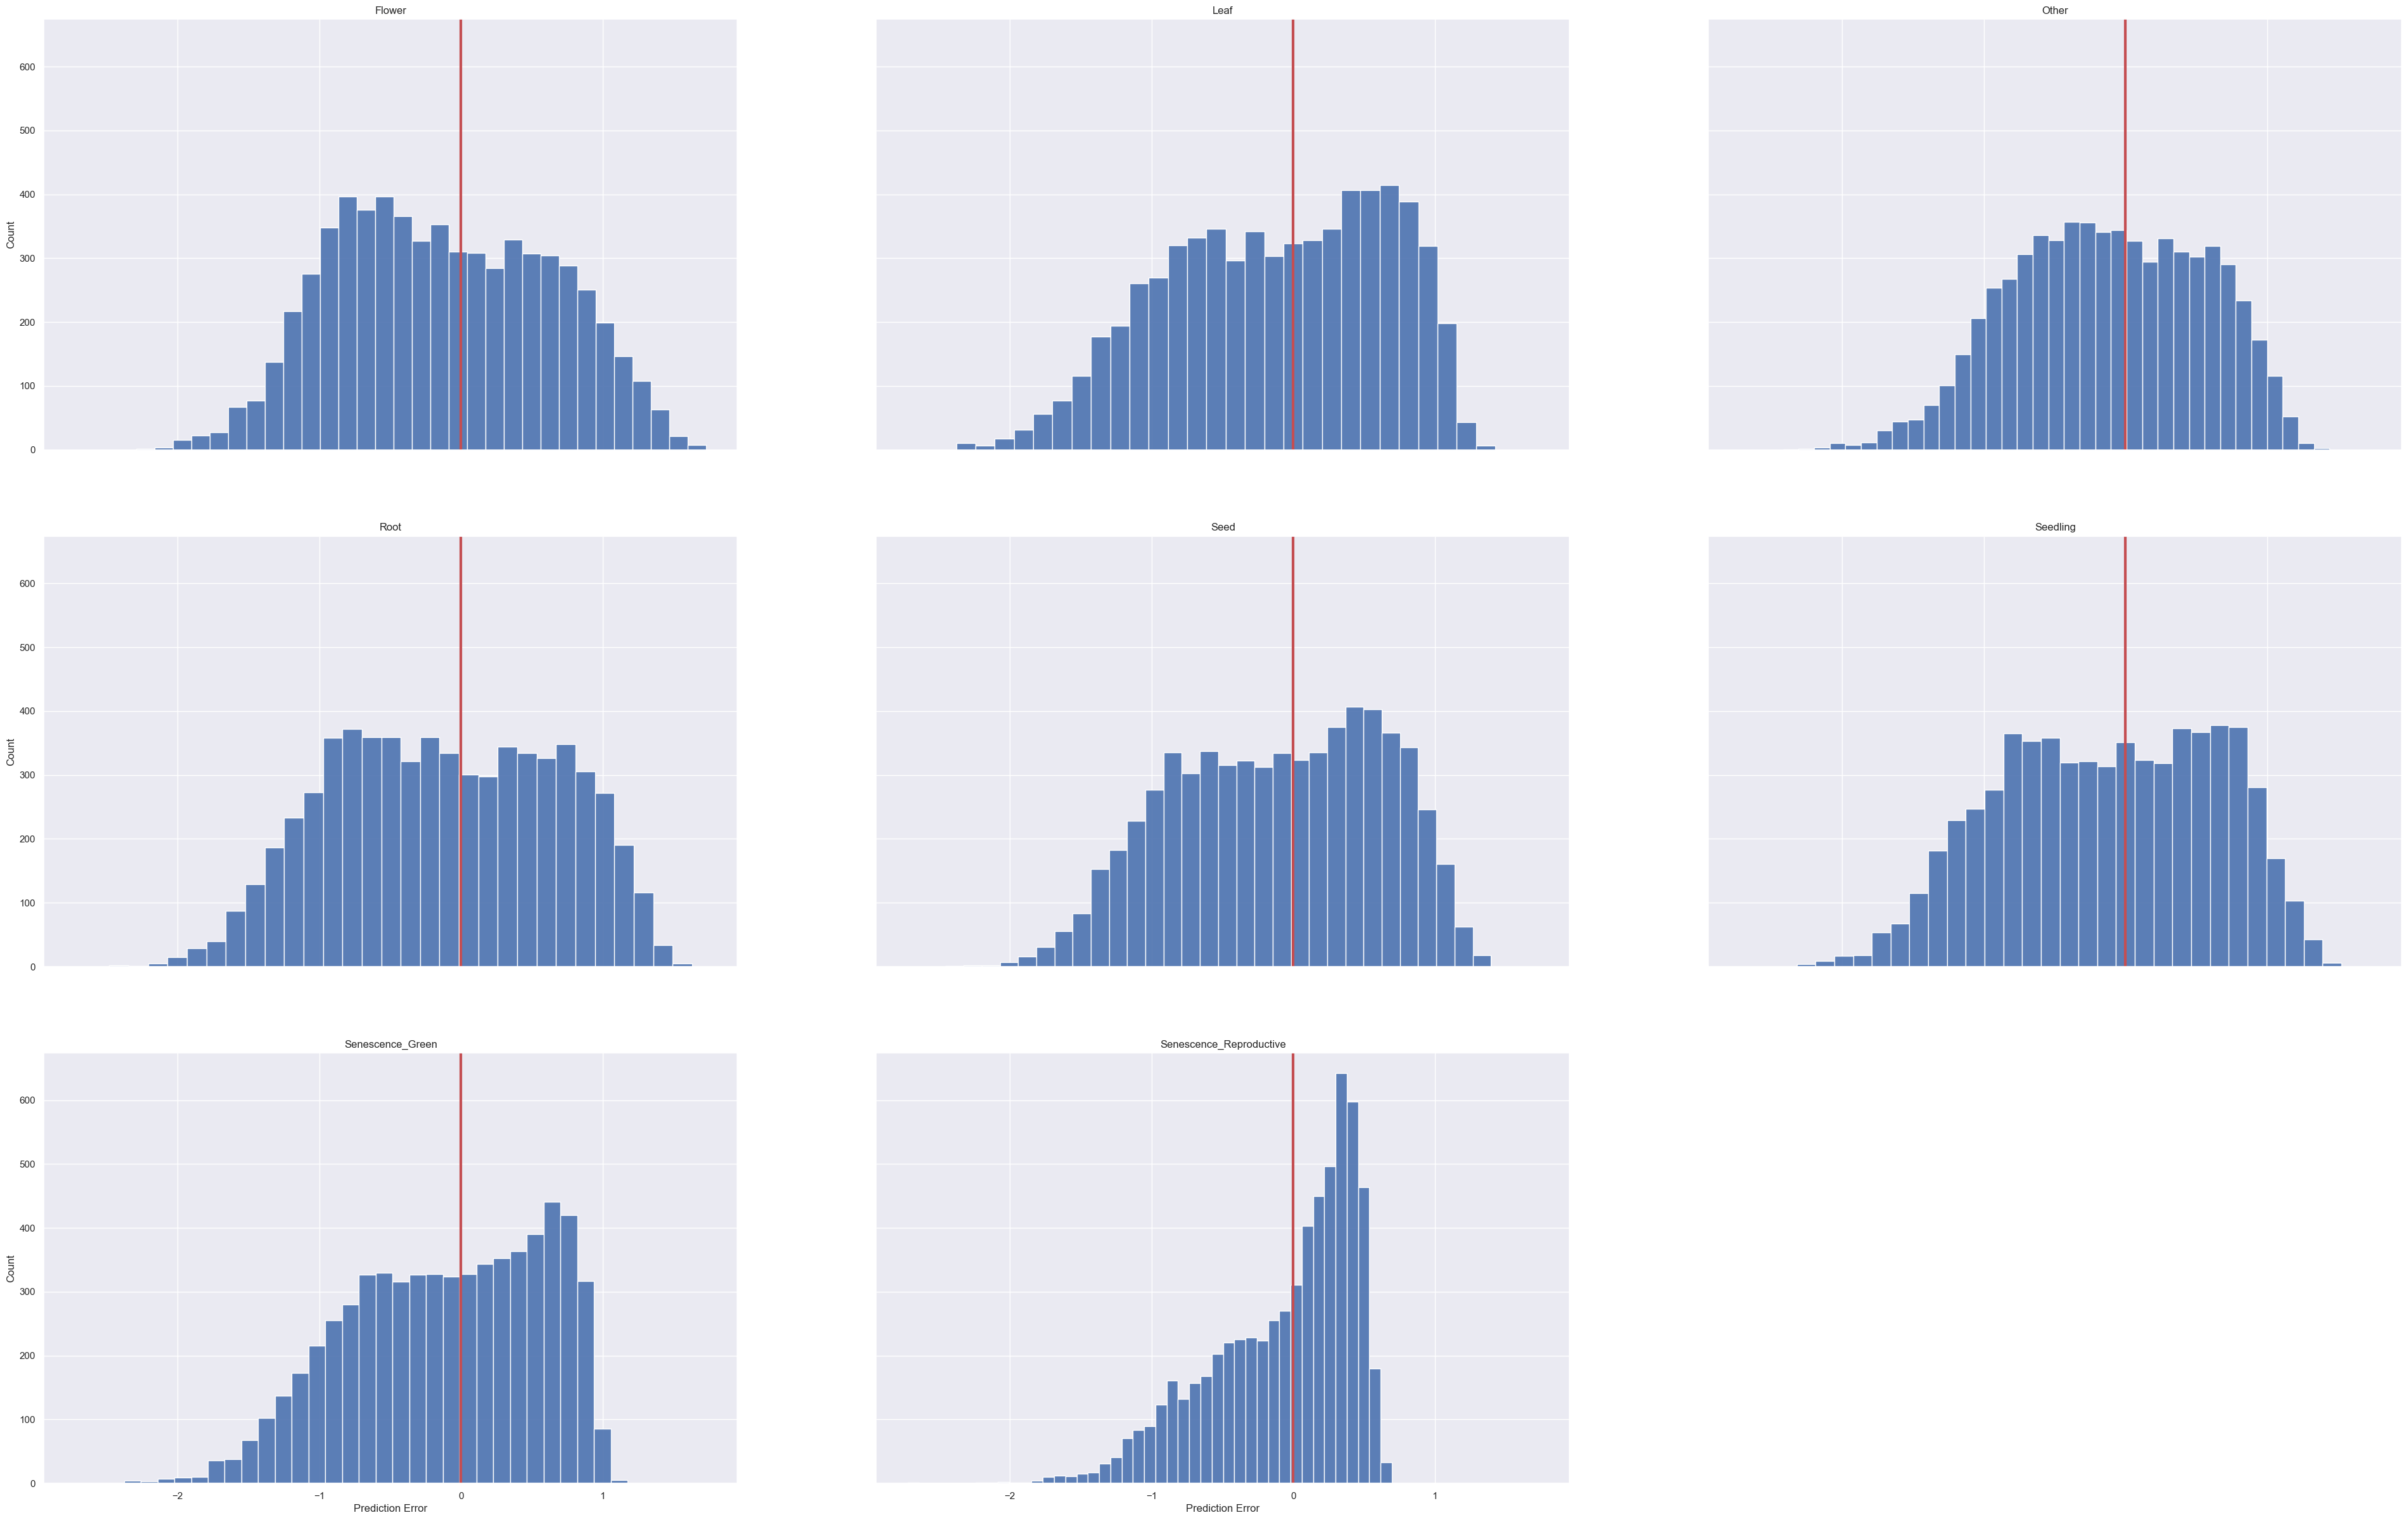

In [27]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

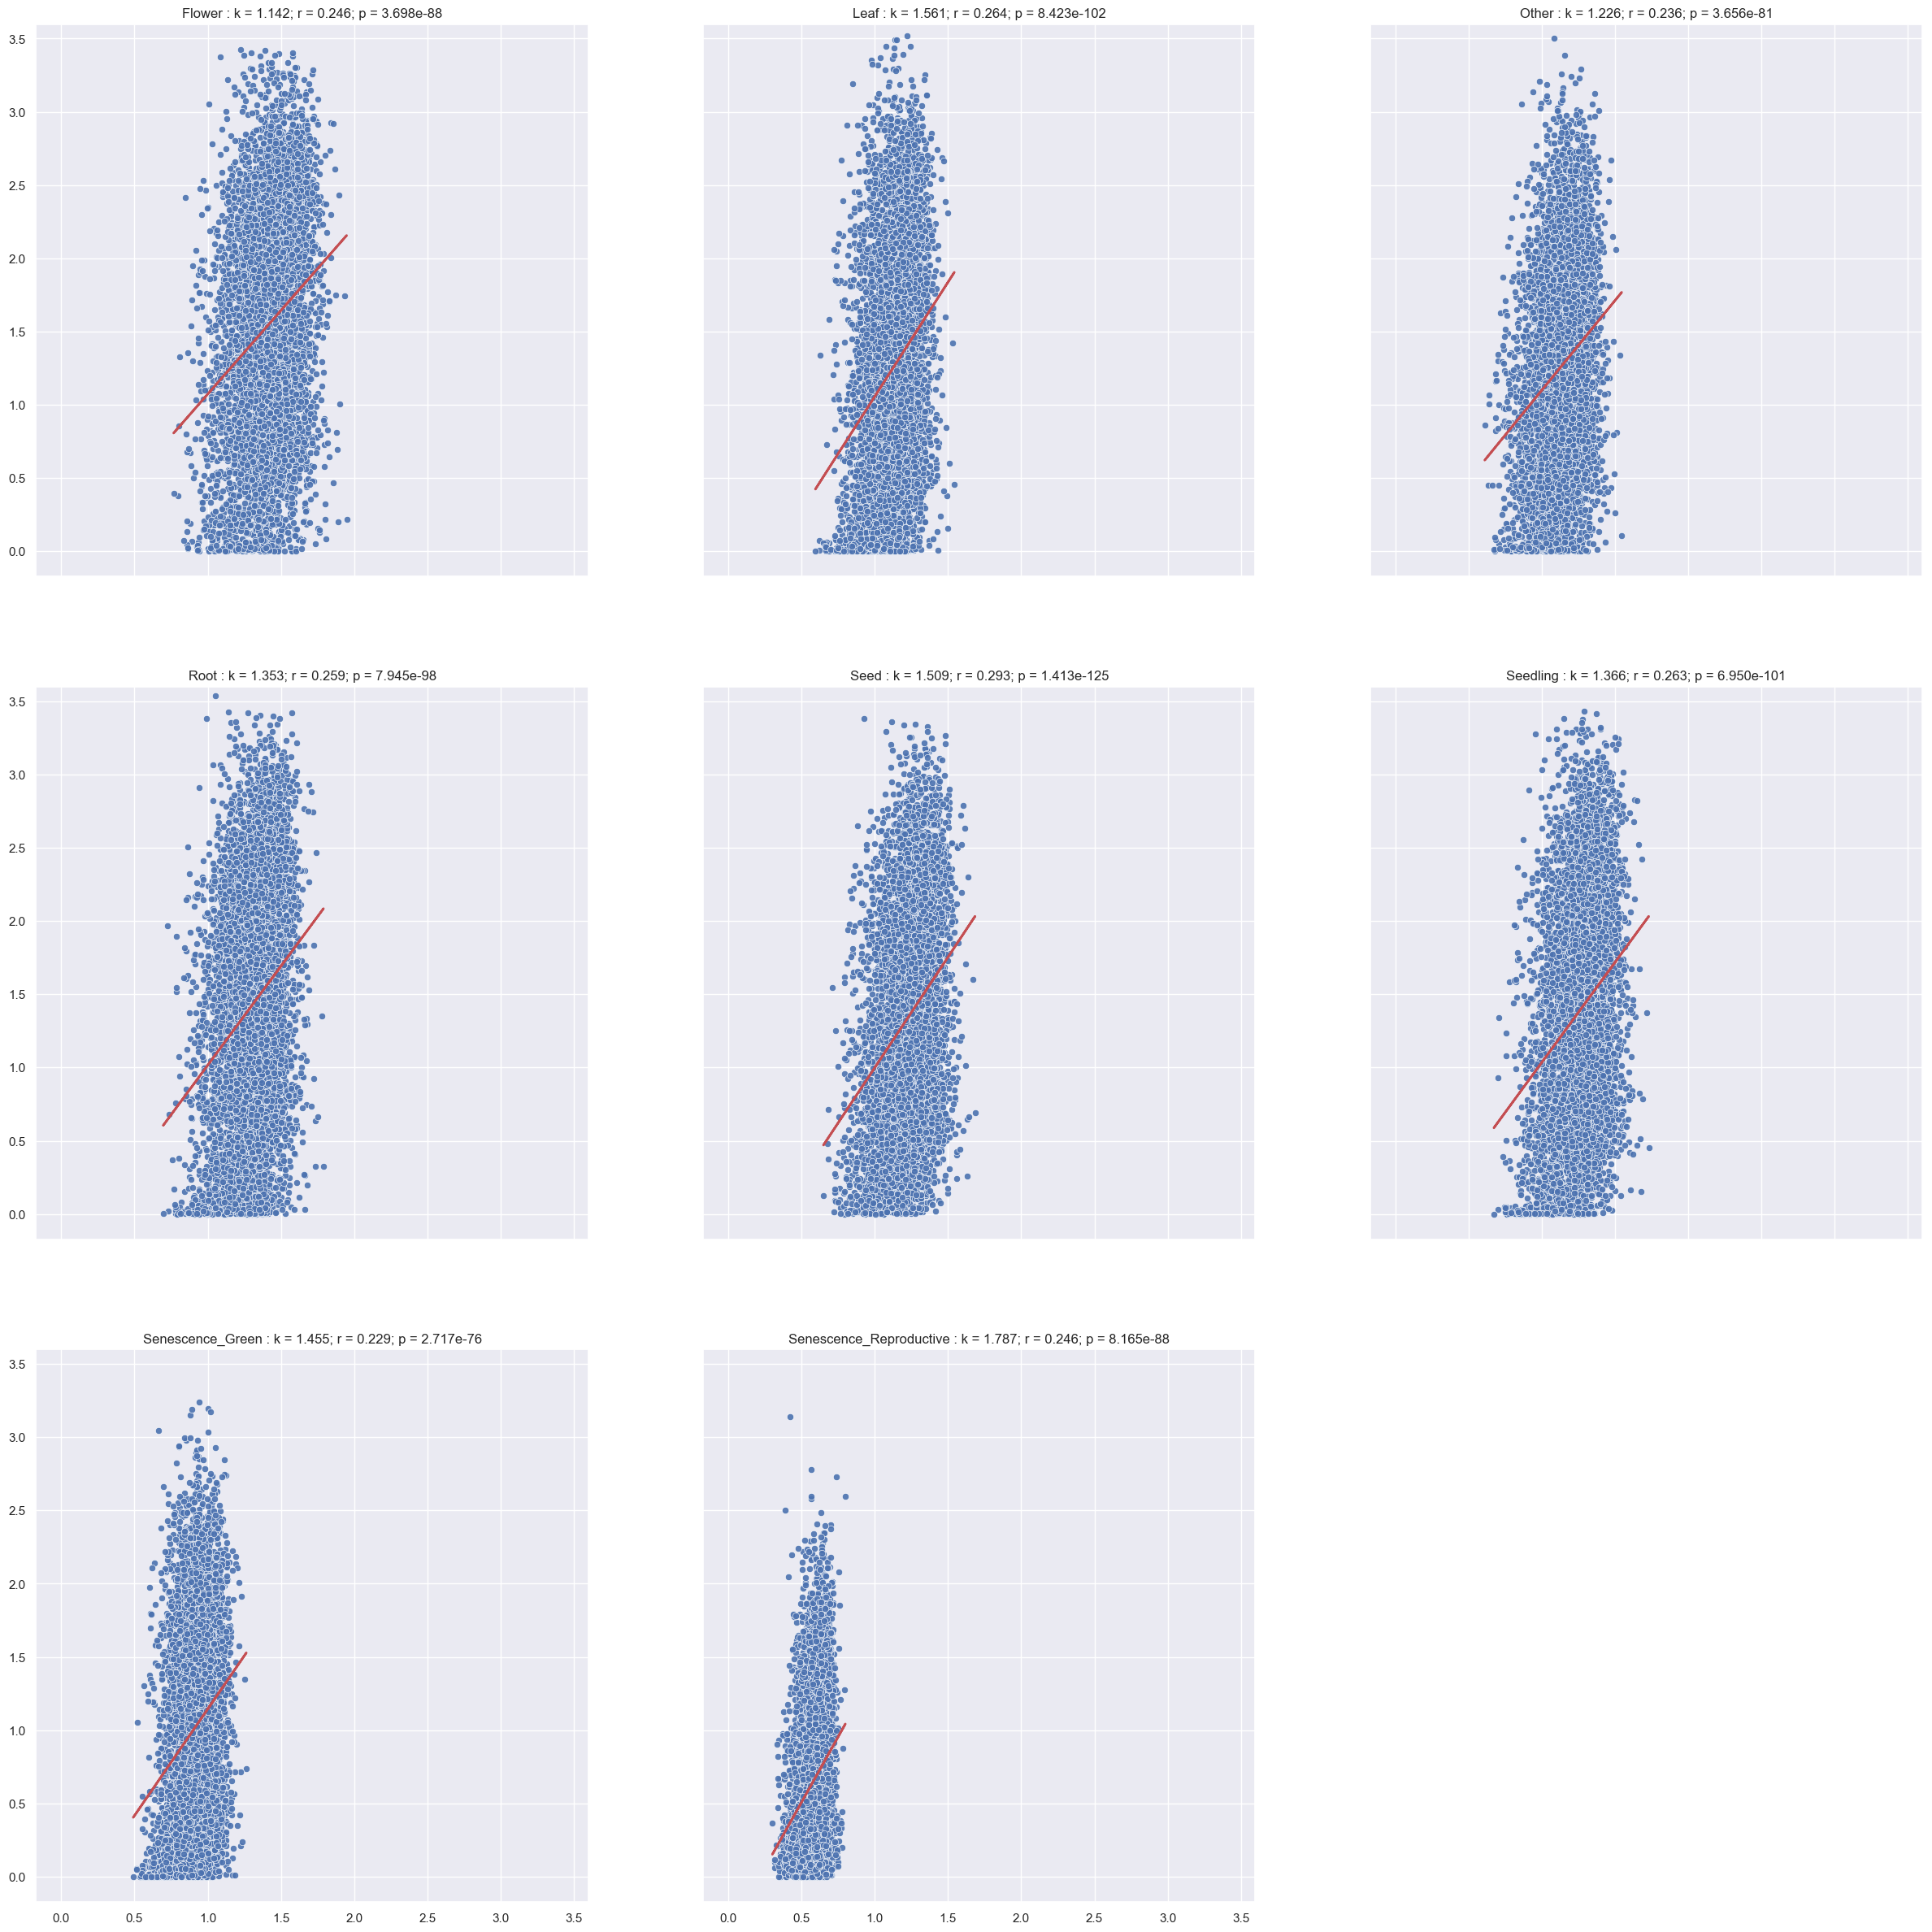

In [28]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

In [29]:
# Display the evaluation accuracy

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy : 44.48785 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
7  senescence_reproductive   6336   3980    62.816    0.408    0.304
6         senescence_green   6336   3873    61.127    0.579    0.376
2                    other   6336   3445    54.372    0.569    0.381
4                     seed   6336   2705    42.693    0.625    0.394
1                     leaf   6336   2311    36.474    0.660    0.421
5                 seedling   6336   2261    35.685    0.649    0.410
3                     root   6336   2182    34.438    0.678    0.419
0                   flower   6336   1793    28.299    0.653    0.407

### 2.4.2 Best Model

In [30]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 5
Loss  : 0.51795


<All keys matched successfully>

In [31]:
# Evaluate the model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [32]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.04370
MAE Loss :  0.60021
MSE Loss :  0.50938


In [33]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT4G27900.2
True : [ 1.91877    0.99054    1.51904    1.17411    1.89875    1.12246    0.67408    0.64914]
Pred : [ 1.54237    1.22898    1.24232    1.41557    1.32019    1.36509    1.01016    0.63685]
 MAE : [ 0.37640    0.23844    0.27672    0.24146    0.57856    0.24263    0.33608    0.01229]
 MSE : [ 0.14168    0.05686    0.07657    0.05830    0.33473    0.05887    0.11295    0.00015]
 R2  : [ 0.03487    0.05304    0.00783   -0.02169    0.04503    0.04442    0.03416    0.00985]

Gene : AT1G74300.1
True : [ 1.34313    1.46030    1.04853    1.51329    1.21106    1.24496    1.22121    0.43134]
Pred : [ 1.58917    1.26542    1.27982    1.45745    1.35902    1.40498    1.03911    0.65580]
 MAE : [ 0.24604    0.19489    0.23129    0.05584    0.14796    0.16001    0.18210    0.22446]
 MSE : [ 0.06053    0.03798    0.05349    0.00312    0.02189    0.02560    0.03316    0.05038]
 R2  : [ 0.02829    0.04102   -0.01591    0.04628    0.05547    0.04459    0.02517    0.06235]



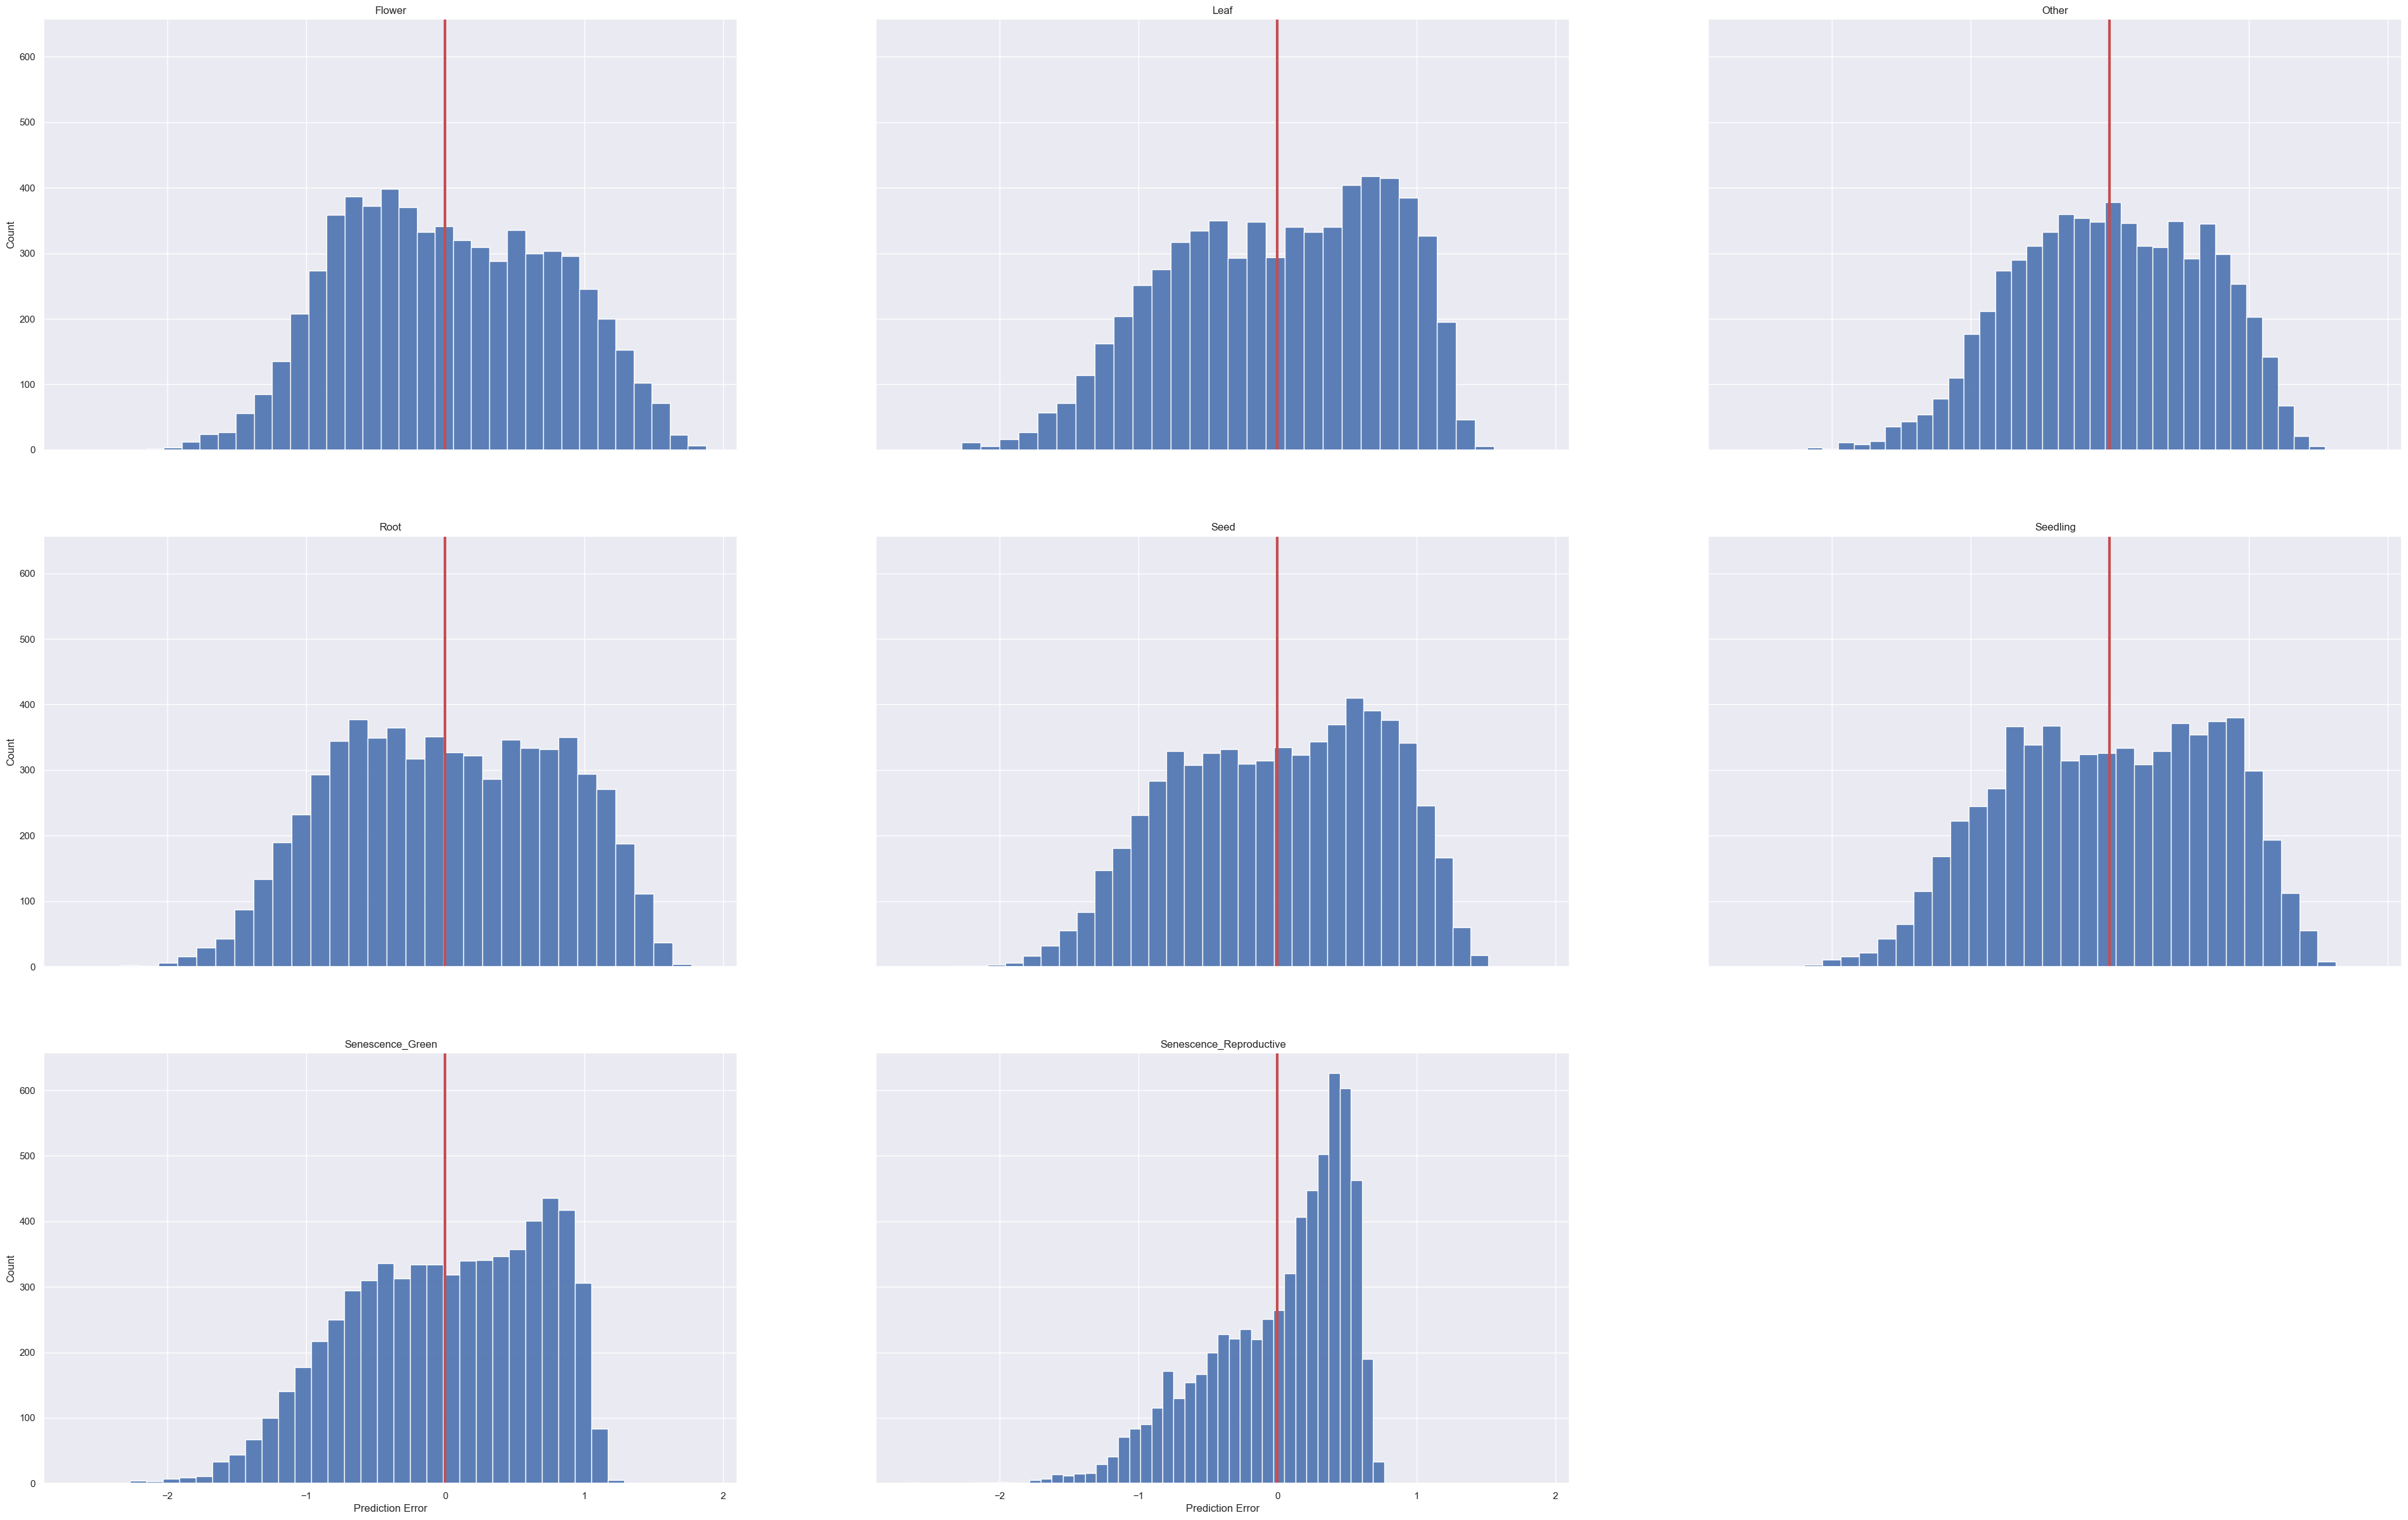

In [34]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

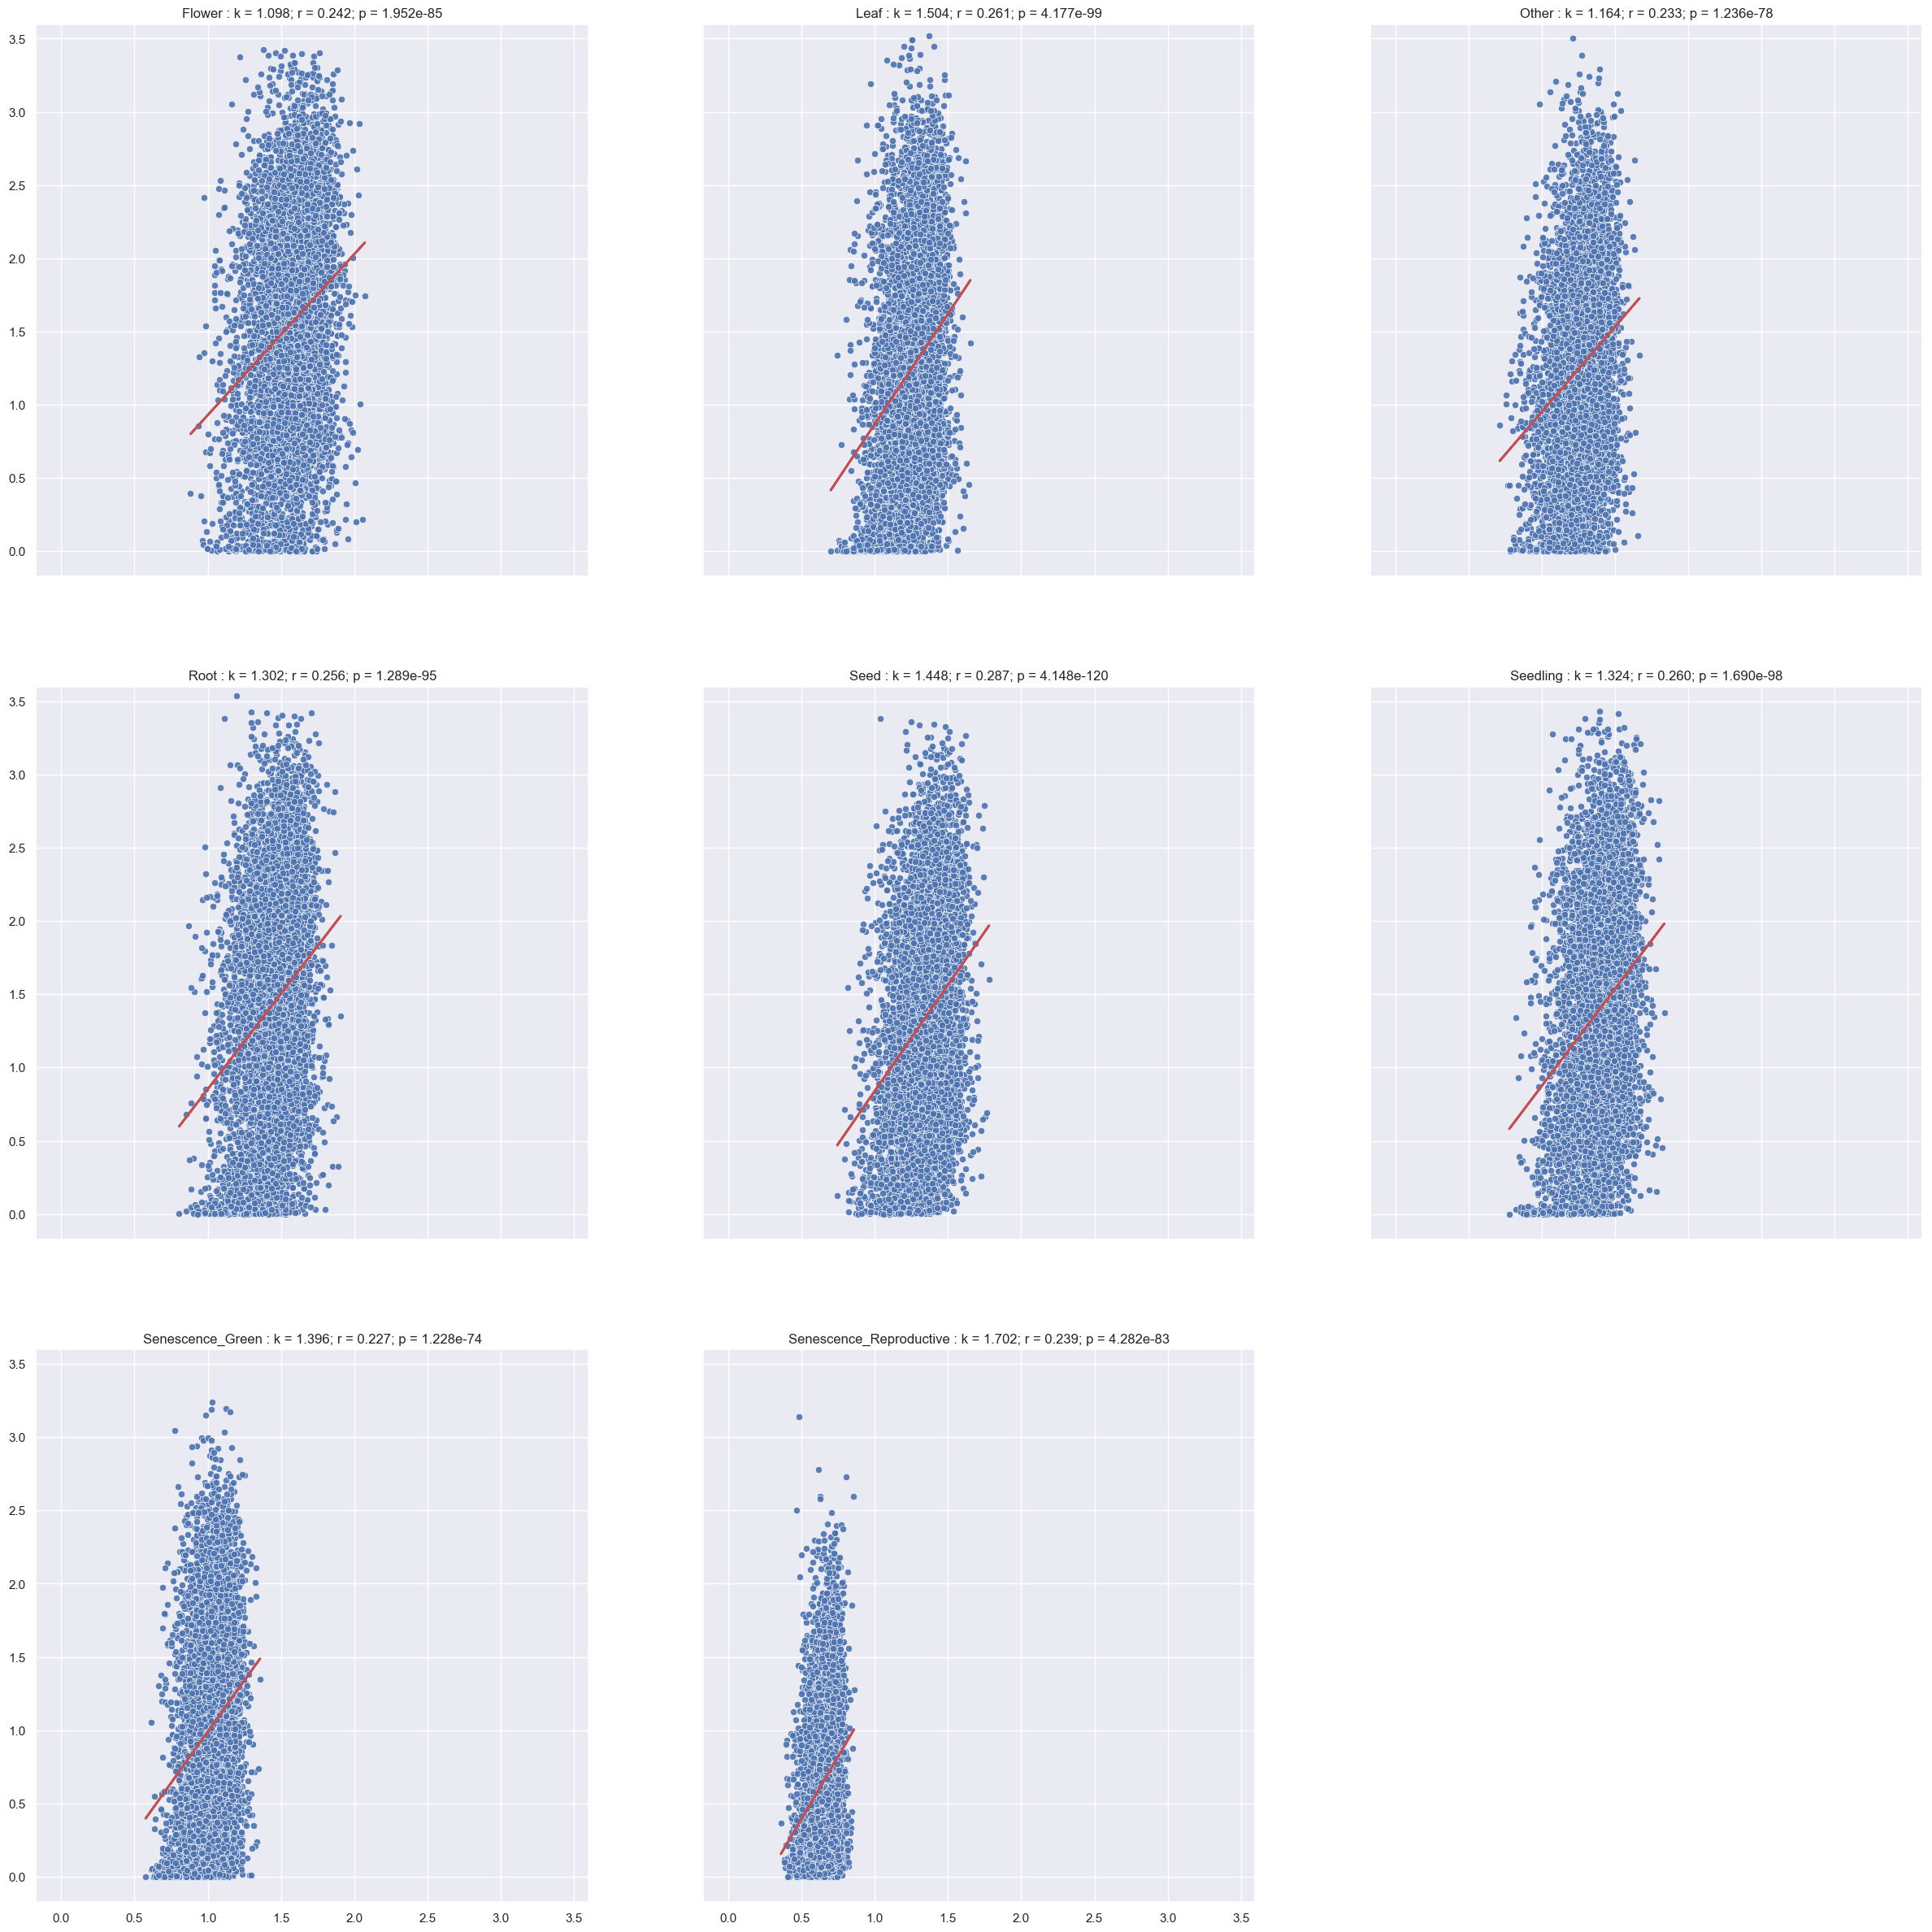

In [35]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

In [36]:
# Display the evaluation accuracy

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy : 43.97491 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
6         senescence_green   6336   3890    61.395    0.579    0.361
7  senescence_reproductive   6336   3853    60.811    0.419    0.281
2                    other   6336   3475    54.845    0.562    0.370
4                     seed   6336   2640    41.667    0.625    0.380
1                     leaf   6336   2260    35.669    0.661    0.403
5                 seedling   6336   2217    34.991    0.645    0.397
3                     root   6336   2157    34.044    0.671    0.413
0                   flower   6336   1798    28.378    0.640    0.405